### A notebook that sources preprocessed data from the seafloor public bucket 

In [3]:
#need this first so TILEDB can find it
import os
os.environ['AWS_PROFILE'] = 'prod'

In [24]:
#imports
from es_sfgtools.data_mgmt.ingestion.archive_pull import load_site_metadata
from es_sfgtools.workflows.workflow_handler import WorkflowHandler
from es_sfgtools.config.env_config import Environment
import pandas as pd
from datetime import datetime, timezone, UTC

In [62]:
# set network/station/campaign and get metadata
NETWORK = "cascadia-gorda"
STATION = "NCC1"
CAMPAIGN_NAME = "2025_A_1126"

metadata = load_site_metadata(NETWORK, STATION)
metadata

Loading site metadata from https://data.earthscope.org/archive/seafloor/metadata/cascadia-gorda/NCC1.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1126.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1126.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1063.json
Loading vessel metadata from https://data.earthscope.org/archive/seafloor/metadata/vessels/1065.json


Site(names=['NCC1'], networks=['cascadia-gorda'], timeOrigin=datetime.datetime(2021, 10, 1, 0, 0), localGeoidHeight=-27.43, arrayCenter=Location(latitude=41.6569428, longitude=-124.93880652, elevation=-27.43), campaigns=[Campaign(name='2025_A_1126', type='measure', vesselCode='1126', start=datetime.datetime(2025, 9, 7, 20, 27), end=datetime.datetime(2025, 9, 13, 7, 12), vessel=Vessel(name='1126', type='waveglider', model='sv3', serialNumber=None, start=datetime.datetime(2023, 2, 1, 0, 0), end=None, imuSensors=[], atdOffsets=[AtdOffset(serialNumber='641-0654', x=0.0, y=0.00053, z=0.92813)], gnssAntennas=[GnssAntenna(type='novatel', serialNumber='NMLM22110020V', start=datetime.datetime(2023, 2, 28, 0, 0), order='primary', model='GNSS-802L', radomeSerialNumber=None, end=None), GnssAntenna(type='novatel', serialNumber='NMLM22090012Z', start=datetime.datetime(2023, 2, 28, 0, 0), order='secondary', model='GNSS-802L', radomeSerialNumber=None, end=None)], gnssReceivers=[], acousticTransducers=

In [63]:
# print surveys for campaign from metadata
print("Surveys for campaign:", CAMPAIGN_NAME)
for campaign in metadata.campaigns:
    if campaign.name == CAMPAIGN_NAME:
        for survey in campaign.surveys:
            print("  ", survey.id, survey.start, survey.end)

Surveys for campaign: 2025_A_1126
   2025_A_1126_1 2025-09-07 20:27:00 2025-09-08 13:40:00
   2025_A_1126_2 2025-09-08 13:40:00 2025-09-12 19:33:00
   2025_A_1126_3 2025-09-12 19:33:00 2025-09-13 07:12:00


In [64]:
# load the data from S3
S3_SYNC_BUCKET = "seafloor-public-bucket-bucket83908e77-6ial2vrmrawf"
WORKING_ENVIRONMENT_KEY = "GEOLAB"
MAIN_DIRECTORY_GEOLAB_KEY = "/Users/mikegottlieb/data/"
os.environ["S3_SYNC_BUCKET"] = S3_SYNC_BUCKET
os.environ["WORKING_ENVIRONMENT"] = WORKING_ENVIRONMENT_KEY
os.environ["MAIN_DIRECTORY_GEOLAB"] = MAIN_DIRECTORY_GEOLAB_KEY
env = Environment()
env.load_working_environment()
env.working_environment()


<WorkingEnvironment.GEOLAB: 'GEOLAB'>

In [65]:
workflow = WorkflowHandler()

workflow.set_network_station_campaign(
    network_id=NETWORK,
    station_id=STATION,
    campaign_id=CAMPAIGN_NAME
)

Changed working station to cascadia-gorda NCC1 2025_A_1126


In [66]:
workflow.midprocess_prep_garpos(override=True) 

Network cascadia-gorda already exists.
Station NCC1 already exists in network cascadia-gorda
Campaign 2022_A_1065 already exists in station NCC1
Campaign 2023_A_1063 already exists in station NCC1
Campaign 2024_A_1126 already exists in station NCC1
Campaign 2025_A_1126 already exists in station NCC1
WorkingEnvironment.GEOLAB


Processing survey 2025_A_1126_1
Filtered 1728 records from shot data based on filtering criteria: acoustic_filters=AcousticFilterConfig(enabled=False, level=<FilterLevel.OK: 'OK'>) ping_replies=PingRepliesFilterConfig(enabled=False, min_replies=3) max_distance_from_center=MaxDistFromCenterConfig(enabled=True, max_distance_m=150.0) pride_residuals=PrideResidualsConfig(enabled=False, max_residual_mm=8.0)
Remaining shot data records: 2452
Shot data prepared and saved to /Users/mikegottlieb/data/cascadia-gorda/NCC1/2025_A_1126/2025_A_1126_1/GARPOS/2025_A_1126_1_circledrive_shotdata_filtered_rectified.csv
Processing survey 2025_A_1126_2
Removed 0 records > 150.0m horizontal distance from array center
Filtered 4959 records from shot data based on filtering criteria: acoustic_filters=AcousticFilterConfig(enabled=False, level=<FilterLevel.OK: 'OK'>) ping_replies=PingRepliesFilterConfig(enabled=False, min_replies=3) max_distance_from_center=MaxDistFromCenterConfig(enabled=True, max_distance_m=1

In [67]:
#read shot data dfs from disk
def read_shotdata_file(filepath):
    return pd.read_csv(filepath, sep=",", header=0, index_col=0)

#make a plot showing the metadata and shotdata time windows from multiple surveys on the same plot
#make the lines thicker and add markers

def plot_shotdata_time_windows(station_name, metadata_time_windows, shotdata_time_windows):
    import matplotlib.pyplot as plt
    colors = ['blue', 'orange', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    plt.figure(figsize=(10, 5))
    # use barh to plot windows
    #only show legend for first survey
    for i, survey_name in enumerate(metadata_time_windows.keys()):
        plt.barh(i-.1, metadata_time_windows[survey_name][1] - metadata_time_windows[survey_name][0], left=metadata_time_windows[survey_name][0], color=colors[0], label='Metadata' if i == 0 else "", height=0.2)
        plt.barh(i + 0.1, shotdata_time_windows[survey_name][1] - shotdata_time_windows[survey_name][0], left=shotdata_time_windows[survey_name][0], color=colors[1], label='Shotdata' if i == 0 else "", height=0.2)
    plt.ylim(-0.5, len(metadata_time_windows))
    plt.yticks(range(len(metadata_time_windows)), list(metadata_time_windows.keys()))
    plt.title(f"Survey Time Windows for Station {station_name}")
    plt.legend()
    plt.show()



2025_A_1126_1
  Metadata Start: 2025-09-07 20:27:00,       End: 2025-09-08 13:40:00
  Shotdata Start: 2025-09-07 20:16:30+00:00, End: 2025-09-08 10:08:37+00:00
2025_A_1126_2
  Metadata Start: 2025-09-08 13:40:00,       End: 2025-09-12 19:33:00
  Shotdata Start: 2025-09-08 00:00:03+00:00, End: 2025-09-08 10:08:37+00:00
2025_A_1126_3
  Metadata Start: 2025-09-12 19:33:00,       End: 2025-09-13 07:12:00
  Shotdata Start: 2025-09-12 00:00:11+00:00, End: 2025-09-13 06:49:15+00:00


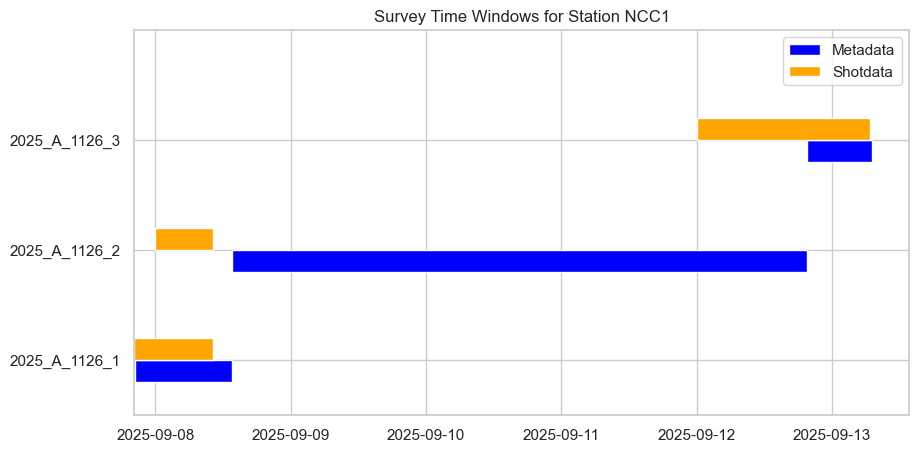

In [68]:

gh = workflow.modeling_get_garpos_handler()
gh.set_network = NETWORK
gh.set_station = STATION
gh.set_campaign = CAMPAIGN_NAME
metadata_surveys = []
for campaign in metadata.campaigns:
    if campaign.name == CAMPAIGN_NAME:
        metadata_surveys = campaign.surveys

metadata_time_windows = {}
shotdata_time_windows = {}
for survey_name in sorted(gh.current_campaign_dir.surveys):
    if survey_name in [survey.id for survey in metadata_surveys]:
        print(f"{survey_name}")
        
        for survey in metadata_surveys:
            if survey.id == survey_name:
                print(f"  Metadata Start: {survey.start},       End: {survey.end}")
                metadata_start = survey.start.replace(tzinfo=UTC)
                metadata_end = survey.end.replace(tzinfo=UTC)
                metadata_time_windows[survey_name] = (metadata_start, metadata_end)
            continue
        try:
            shotdata_filepath = gh.current_campaign_dir.surveys[survey_name].shotdata
            shotdata_df = read_shotdata_file(shotdata_filepath)
            #use utc
            start = datetime.fromtimestamp(shotdata_df['pingTime'].iloc[0], tz=timezone.utc)
            end = datetime.fromtimestamp(shotdata_df['pingTime'].iloc[-1], tz=timezone.utc)
            print(f"  Shotdata Start: {start}, End: {end}")

            shotdata_time_windows[survey_name] = (start, end)
            
        except Exception as e:
            print(e)

plot_shotdata_time_windows(STATION, metadata_time_windows, shotdata_time_windows)